# Calculate Exposed Population to IPC-Class 3

This script makes use of the FEWSNET Food Security classification, which is classified according to the [Integrated Phase Classification (IPC) V3.0](https://fews.net/IPC). 

The zips files to be downloaded in this script contains three files 

* _CS: Current Situation
* _ML1: Near-term projection - (next month)
* _ML2: Medium-term projection - (next four months)

The shapefiles contain the phases of food security for that period. The five phases are: 
1. Minimal
2. Stressed
3. Crisis
4. Emergency
5. Famine

Other additional values which might occur in the shapefiles include 
66 = water, 88 = parks, forests, reserves, 99 = No Data or Missing Data. 

More information [FEWSNET Food Securty Data](http://shapefiles.fews.net.s3.amazonaws.com/HFIC/FEWS_NET_Food_Security_Data_v3.pdf)

# Import packages

In [1]:
#!/usr/bin/env python
# coding: utf-8

#Make sure you have the ritht folder structure
#../data/Shapefile
# .../data/Shapefile/South_Africa_Zips

import subprocess
import requests
import urllib.request
import zipfile
import os
import shutil
import geopandas as gpd
from bs4 import BeautifulSoup
import urllib.request
from os import listdir
from os.path import isfile, join
import pandas as pd
import ee
import os
import glob
from zipfile import ZipFile
import datetime as dt

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
 
import descartes 
import mapclassify
from matplotlib.pyplot import figure 

**NOTE IF YOU ALREADY DOWNLOADED THE DATA, SCROLL DOWN TO START THE SCRIPT FROM 2.**

# 1. Download data from FEWSNET via Google Earth Engine

In [5]:
ee.Authenticate()

Enter verification code: 4/1AY0e-g4qqyoLXL3moYQ4UwVAV93plt7qt3HbvE89bheZN2HkCFkg7cZaJH8

Successfully saved authorization token.


In [6]:
ee.Initialize()

In [7]:
ex = ['.shp', '.prj', '.dbf', '.shx']
file_paths = []
i=1

def zipshape(directory,export):
    for (root, directories, files) in os.walk(directory):
        for filename in files:
            if filename.endswith('.shp'):
                file_paths=[]
                filebase = filename.split('.')[0]
                try:
                    for things in ex:
                        if os.path.exists(os.path.join(root, filebase+things)):
                            filepath = os.path.join(root, filebase+things)
                            #print(filepath)
                            file_paths.append(filepath)
                    os.chdir(export)
                    if not os.path.exists(filebase+'.zip') and int(len(file_paths))==int(4):
                        with ZipFile(filebase+'.zip','w') as zip:
                            print("Creating zipped folder "+str(filebase)+'.zip'+' at '+str(export))
                            # writing each file one by one
                            for file in file_paths:
                                fname=os.path.basename(file)
                                zip.write(file,fname)
                    else:
                        print('File already exists: '+str(filebase+'.zip')+' SKIPPING')
                except:
                    pass


In [8]:
os.getcwd() #current working directory

'D:\\Drought_IBF\\zwe'

In [1]:
mypath= "C:/Users/MPanis/Rode Kruis/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/Shapefile"

#make the files data/Shapefile/South_Africa_Zips/

Create URL For the Area of interest, copy-paste the url from the browser and change the page=number into **page={0}".format(pagenum)** 

In [10]:
url_download_list_zip = []

for pagenum in range (0,100):
    #Main page url for Western Africa
    #url = "https://fews.net/fews-data/333?tid=11&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=&page={0}".format(pagenum)
    # Main page url for East Africa
    #url = "http://fews.net/fews-data/333?tid=23&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=&page={0}".format(pagenum)
    #Main page url for Southern Africa
    url = "https://fews.net/fews-data/333?tid=34&field_data_portal_date_start%5Bvalue%5D%5Byear%5D=2009&field_data_portal_date_start%5Bvalue%5D%5Bmonth%5D=1&field_data_portal_date_end%5Bvalue%5D%5Byear%5D=2020&field_data_portal_date_end%5Bvalue%5D%5Bmonth%5D=12&page={0}".format(pagenum)

    print("Page number:" + str(pagenum))
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, from_encoding=resp.info().get_param('charset'))
    link_list = []
    
    # Find all links from main page
    for link in soup.find_all('a', href=True): 
        link_list.append(link['href'])
        
    # if it contains node, it mains that there is data on that page number
    if any("/node/" in s for s in link_list):
        
        # we only need the content link that links to the zipfile data (shapefiles)
        url_download_list = [s for s in link_list if "/content/" in s]
        
        #Find all zip files and on that link and save that in a list
        for downloadurl in url_download_list:
            resp = urllib.request.urlopen("http://fews.net/{0}".format(downloadurl))
            soup = BeautifulSoup(resp, "lxml", from_encoding=resp.info().get_param('charset'))
            
            link_list = []
            for link in soup.find_all('a', href=True): 
                link_list.append(link['href'])
            url_download_list_zip.append([s for s in link_list if ".zip" in s][0])  
    else:
        break
        
# zip occurs twice in the extracted website link list, remove duplicates:        
url_download_list_zip = list(set(url_download_list_zip))


Page number:0
Page number:1
Page number:2
Page number:3
Page number:4
Page number:5
Page number:6


In [12]:
url_download_list_zip

['http://s3.amazonaws.com/shapefiles.fews.net/HFIC/SA/southern-africa201910.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201207.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201007.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201812.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201507.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201310.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa202010.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201806.zip',
 'http://s3.amazonaws.com/shapefiles.fews.net/HFIC/SA/southern-africa202002.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201010.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa201606.zip',
 'http://shapefiles.fews.net.s3.amazonaws.com/HFIC/SA/southern-africa202007.zip',
 'http://shapefi

In [13]:
for zipfile_url in url_download_list_zip:

    filename = zipfile_url.rsplit('/', 1)[-1]

    print("Downloading shapefile {0}".format(filename))

    urllib.request.urlretrieve('{0}'.format(zipfile_url), '{0}/South_Africa_Zips/{1}'.format(mypath, filename))
    # Extract all files into a single folder:
    archive = zipfile.ZipFile('{0}/South_Africa_Zips/{1}'.format(mypath, filename), 'r')
    archive.extractall(path="{0}/South_Africa_Assets/".format(mypath))


In [14]:
# Convert files to zips in the folder

zipshape("C:/Users/MPanis/Rode Kruis/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/Shapefile/South_Africa_Assets",
         "C:/Users/MPanis/Rode Kruis/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/Shapefile/South_Africa_Assets_Processed")

File already exists: Lakes.zip SKIPPING
Creating zipped folder SA_200907_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: SA_200907_ML1.zip SKIPPING
File already exists: SA_200907_ML2.zip SKIPPING
Creating zipped folder SA_200910_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: SA_200910_ML1.zip SKIPPING
File already exists: SA_200910_ML2.zip SKIPPING
Creating zipped folder SA_201001_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: SA_201001_ML1.zip SKIPPING
File already exists: SA_201001_ML2.zip SKIPPING
Creating zipped folder SA_201004_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: SA_201004_ML1.zip SKIPPING
File already exists: SA_201004_ML2.zip SKIPPING
Creating zipped folder SA_201007_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: SA_201007_ML1.zip SK

File already exists: SA_202006_ML1.zip SKIPPING
File already exists: SA_202006_ML2.zip SKIPPING
File already exists: SA_202007_ML1.zip SKIPPING
File already exists: SA_202007_ML2.zip SKIPPING
File already exists: SA_202008_ML1.zip SKIPPING
File already exists: SA_202008_ML2.zip SKIPPING
File already exists: SA_202009_ML1.zip SKIPPING
File already exists: SA_202009_ML2.zip SKIPPING
Creating zipped folder SA_202010_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: SA_202010_ML1.zip SKIPPING
File already exists: SA_202010_ML2.zip SKIPPING
Creating zipped folder SA_202012_ML1.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
Creating zipped folder SA_202012_ML2.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
Creating zipped folder WA_202002_CS.zip at D:/Drought_IBF/zwe/data/Shapefile/South_Africa_Assets_Processed
File already exists: WA_202002_ML1.zip SKIPPING
File already exists: WA_202002_ML2.zip SKI

In [15]:
# order into three folders 
mypath2="C:/Users/MPanis/Rode Kruis/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/Shapefile"
onlyfiles = [f for f in listdir(mypath2 + "/South_Africa_Assets_Processed/") if isfile(join(mypath2 + "/South_Africa_Assets_Processed/", f))]
# do this only one time 
try:
    shutil.rmtree(mypath2 + r"/CS") 
    shutil.rmtree(mypath2 + r"/ML1") 
    shutil.rmtree(mypath2 + r"/ML2") 
except:
    print("directory doesn't excist yet")
os.mkdir(mypath2 + r"/CS")
os.mkdir(mypath2 + r"/ML1")
os.mkdir(mypath2 + r"/ML2")


In [16]:
CS = [s for s in onlyfiles if "CS" in s]

In [17]:
for file in CS:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/CS")
#Note the name of the files, using the correct country area
#EA201702_CS linked to the eastern africa ipc outlooks
#in this case we are interested in Southern Africa, so SA201702_CS
os.rename(mypath2 + r"/CS/SA_201702_CS.zip", mypath2 + r"/CS/SA_201702_CS.zip")
ML1 = [s for s in onlyfiles if "ML1" in s]

for file in ML1:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/ML1")
    
ML2 = [s for s in onlyfiles if "ML2" in s]
for file in ML2:
    shutil.move(mypath2 + "/South_Africa_Assets_Processed/" + file, mypath2 + "/ML2")


## 2. RUN SCRIPT FROM HERE IF YOU HAVE THE DATA ALREADY

In [2]:
one_drive = "C:/Users/BOttow/Rode Kruis"
path = one_drive + "/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability"
mypath2= path + "/Shapefile"

CS = [f for f in listdir(mypath2 + "/CS/") if isfile(join(mypath2 + "/CS/", f))]
ML1 = [f for f in listdir(mypath2 + "/ML1/") if isfile(join(mypath2 + "/ML1/", f))]
ML2 = [f for f in listdir(mypath2 + "/ML2/") if isfile(join(mypath2 + "/ML2/", f))]

In [3]:
print(CS)
mypath2

['SA_200907_CS.zip', 'SA_200910_CS.zip', 'SA_201001_CS.zip', 'SA_201004_CS.zip', 'SA_201007_CS.zip', 'SA_201010_CS.zip', 'SA_201101_CS.zip', 'SA_201104_CS.zip', 'SA_201107_CS.zip', 'SA_201110_CS.zip', 'SA_201201_CS.zip', 'SA_201204_CS.zip', 'SA_201207_CS.zip', 'SA_201210_CS.zip', 'SA_201301_CS.zip', 'SA_201304_CS.zip', 'SA_201307_CS.zip', 'SA_201310_CS.zip', 'SA_201401_CS.zip', 'SA_201404_CS.zip', 'SA_201407_CS.zip', 'SA_201410_CS.zip', 'SA_201501_CS.zip', 'SA_201504_CS.zip', 'SA_201507_CS.zip', 'SA_201510_CS.zip', 'SA_201602_CS.zip', 'SA_201606_CS.zip', 'SA_201610_CS.zip', 'SA_201702_CS.zip', 'SA_201706_CS.zip', 'SA_201710_CS.zip', 'SA_201802_CS.zip', 'SA_201806_CS.zip', 'SA_201810_CS.zip', 'SA_201812_CS.zip', 'SA_201902_CS.zip', 'SA_201906_CS.zip', 'SA_201910_CS.zip', 'SA_202002_CS.zip', 'SA_202006_CS.zip', 'SA_202010_CS.zip', 'WA_202002_CS.zip']


'C:/Users/BOttow/Rode Kruis/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/Shapefile'

### Import shapefiles 

In [4]:
############ ZIMBABWE ############
zwe_lzh = gpd.read_file(one_drive + '/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/zwe_livelihoodzones/ZW_LHZ_2011/ZW_LHZ_2011.shp') #Livelihood zones
district =gpd.read_file(one_drive + '/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/Admin/pop_recalc.shp') #Population Data

## ONEDRIVE FOLDERS ##
##[PRJ] FbF - Zimbabwe - Danish Red Cross . 3.Data - Hazard exposure, vulnerability > Admin > pop_recal.zip 
##[PRJ] FbF - Zimbabwe - Danish Red Cross . 3.Data - Hazard exposure, vulnerability > zwe_livelihoodzones > ZW_LHZ_2011.zip

In [5]:
df_list=list()
for file in CS[20:-1]:
    CS_ = gpd.read_file('zip://' +mypath2 + "/CS/" +file)
    gdf_adm2_cs_merged = gpd.overlay(district, CS_,how='intersection') 
    gdf_adm2_cs_merged["area"]=gdf_adm2_cs_merged['geometry'].area
    df=gdf_adm2_cs_merged.query('CS < 6')
    idx = df.groupby(['ADM2_EN'])['area'].transform(max)==df['area']
    df=df[idx]
    df=df[['ADM2_PCODE', 'CS', '_sum']]
    x=file.split('_')[1] 
    df['Date']=dt.datetime(int(x[:4]),int(x[4:]),1).strftime("%Y-%m-%d")
    df['year']=int(x[:4])
    df_list.append(df.query('CS != "NaN"')) #CS not equal tot NaN
    
df1 = pd.concat(df_list)

df1.to_csv(one_drive + '/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/zwe_ipc/zwe_ipc.csv')

In [6]:
df1

,ADM2_PCODE,CS,_sum,Date,year
0,ZW1601,1.0,82497.809891,2014-07-01,2014
1,ZW1622,1.0,43277.149144,2014-07-01,2014
2,ZW1801,1.0,177287.110881,2014-07-01,2014
3,ZW1201,1.0,149011.109424,2014-07-01,2014
4,ZW1221,1.0,41842.934721,2014-07-01,2014
...,...,...,...,...,...
243,ZW1405,1.0,183576.171458,2020-10-01,2020
245,ZW1304,1.0,136118.797853,2020-10-01,2020
247,ZW1204,1.0,264139.767180,2020-10-01,2020
251,ZW1306,1.0,235660.798792,2020-10-01,2020


### IPC 3 Class Exposed Population 

In [7]:
#Calculate the total population, in order to set a threshold value based on percentage exposed. 
adm2_pop =df1.groupby(['ADM2_PCODE']).max().reset_index()
total_pop = adm2_pop['_sum'].sum()
total_pop

14350726.901129559

<ipython-input-8-51b1066462bb>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0','2m', '4m','6m','8m','10m' ,'12m', '14m'],fontsize='16')


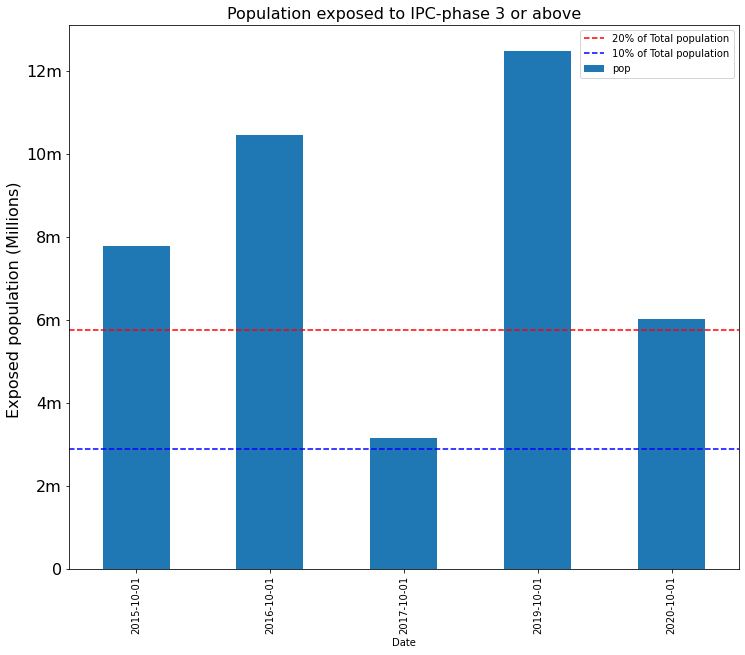

In [8]:
# Merge conflict events with regions they occurred in
fig, ax = plt.subplots(figsize = (12,10)) 

df1 = df1.astype({"_sum": int})
df1['pop']= df1['_sum'] 
df2=df1.groupby(['CS','Date']).sum().reset_index()
oct_mask =pd.to_datetime(df2['Date']).map(lambda x:x.month) == 10
df3 = df2[oct_mask]
df3.query('CS>2').plot.bar(x='Date',y= 'pop',ax=ax,legend=False)
 

plt.title('Population exposed to IPC-phase 3 or above',fontsize='16')
ax.set_yticklabels(['0','2m', '4m','6m','8m','10m' ,'12m', '14m'],fontsize='16')
ax.set_ylabel('Exposed population (Millions) ',fontsize='16')
plt.axhline(y=(0.2*total_pop), color='r', linestyle='dashed', label='20% of Total population')
plt.axhline(y=(0.1*total_pop), color='b', linestyle='dashed', label='10% of Total population') 
plt.legend()

plt.savefig(one_drive + '/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/zwe_ipc/zwe_ipc_class3_.png')

### FEWSNET IPC Maps  

In [9]:
# Several plots will be generated with the function plot_geo:
def plot_geo_acc(df1, district,year):
    fig, ax = plt.subplots(figsize = (20,10)) 
    ax.axis("off")
    df1=df1.query('CS > 1')
    df1 = df1.astype({"CS": int})
    colors2=['#f0f9e8','#ffffb2','#fe9929','#e31a1c','#d94701']
    cmap1 = ListedColormap(colors2)
    #df1.plot(column ='CS',ax=ax, legend = False, cmap =cmap1,linewidth=0.1, edgecolor='0.8',vmin=1, vmax=5)
    district.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
    plt.title('FEWS NET IPC-%s '%year)

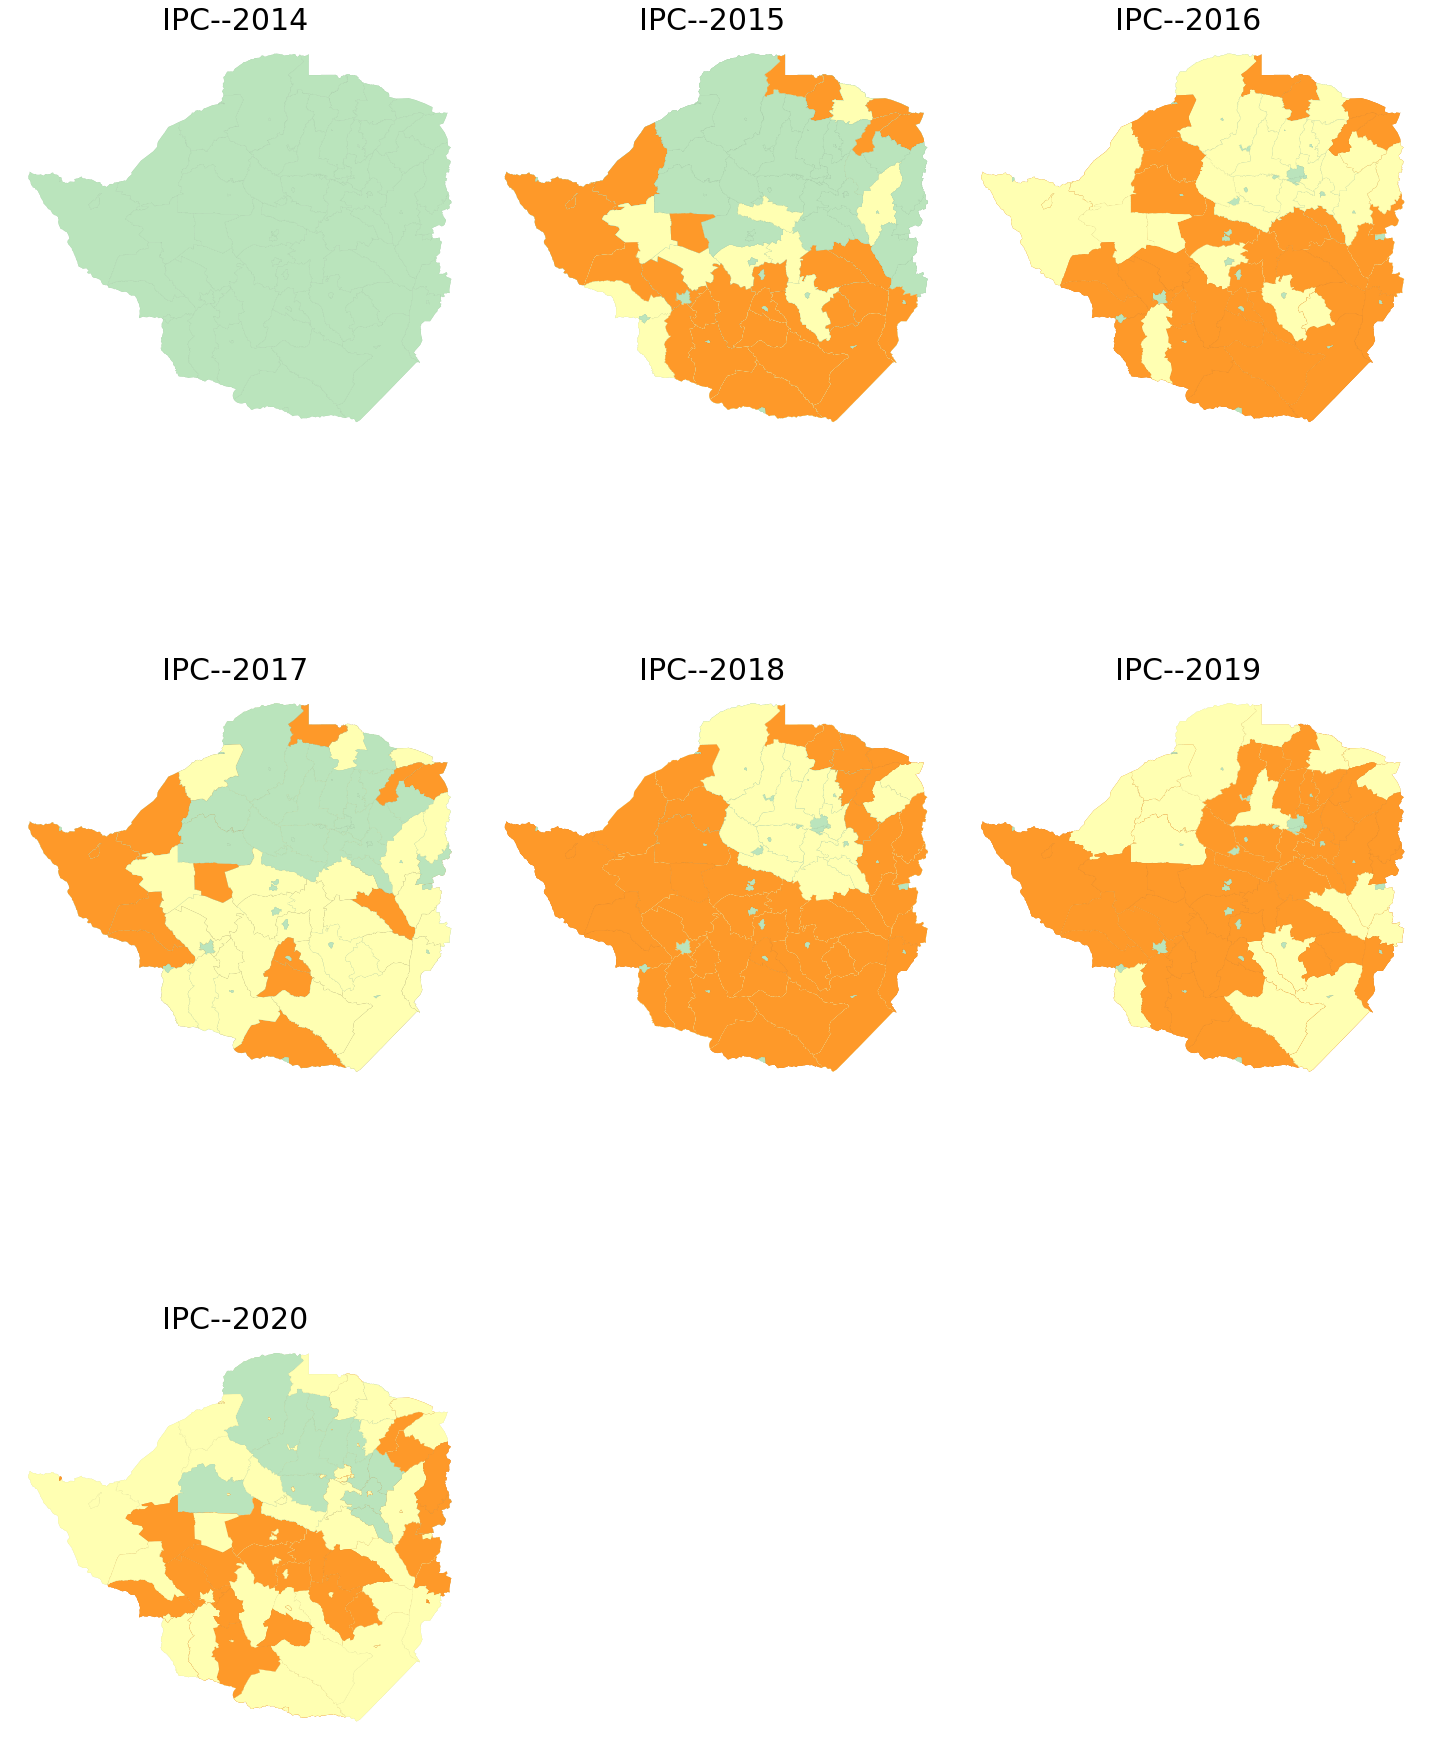

In [11]:
fig1= plt.figure( figsize=(20, 30))
c=5
df2 = district.merge(df1, on = 'ADM2_PCODE')
for i in range(1,8):
    
    ax = fig1.add_subplot(3, 3, i)  # create an axes object in the figure
    
    plot_df=df2.query('year==%s'% (2009+c))
    year='-%s'% (2009+c)
    df=plot_df.query('CS > 1')
    df = df.astype({"CS": int})
    colors2=['#f0f9e8','#bae4bc','#ffffb2','#fe9929','#e31a1c','#59140d']
    cmap1 = ListedColormap(colors2)
    s1=plot_df.plot(column = 'CS',ax=ax, legend = False, cmap =cmap1,linewidth=0.02, edgecolor='0.4',vmin=-0.5, vmax=6)
    ax.axis('off')
    plt.title('IPC-%s '%year,fontsize='30')
    c=c+1
    plt.tight_layout()
    

plt.savefig(one_drive + '/510 - Data preparedness and IBF - [PRJ] FbF - Zimbabwe - Danish Red Cross/3. Data - Hazard exposure, vulnerability/zwe_ipc/zwe_ipc_class.png')